In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle(1).json to kaggle(1).json


In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle(1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jeetblahiri/bccd-dataset-with-mask


Dataset URL: https://www.kaggle.com/datasets/jeetblahiri/bccd-dataset-with-mask
License(s): unknown
 99% 2.12G/2.15G [00:27<00:00, 40.8MB/s]
100% 2.15G/2.15G [00:27<00:00, 83.6MB/s]


In [ ]:
!unzip -q bccd-dataset-with-mask.zip

In [ ]:
import os
os.listdir("/content")

['.config',
 'bccd-dataset-with-mask.zip',
 'BCCD Dataset with mask',
 'kaggle(1).json',
 'sample_data']

In [ ]:
print(os.listdir("/content"))

['.config', 'bccd-dataset-with-mask.zip', 'BCCD Dataset with mask', 'kaggle(1).json', 'sample_data']


In [ ]:
print(os.listdir("/content/BCCD Dataset with mask"))

['train', 'test']


In [ ]:
print(os.listdir("/content/BCCD Dataset with mask/train"))
print(os.listdir("/content/BCCD Dataset with mask/test"))

['original', 'mask']
['original', 'mask']


In [ ]:
train_image_dir = "/content/BCCD Dataset with mask/train/original"
train_mask_dir  = "/content/BCCD Dataset with mask/train/mask"

test_image_dir  = "/content/BCCD Dataset with mask/test/original"
test_mask_dir   = "/content/BCCD Dataset with mask/test/mask"



In [ ]:
import os

print(len(os.listdir(train_image_dir)))
print(len(os.listdir(train_mask_dir)))
print(len(os.listdir(test_image_dir)))
print(len(os.listdir(test_mask_dir)))


1169
1169
159
159


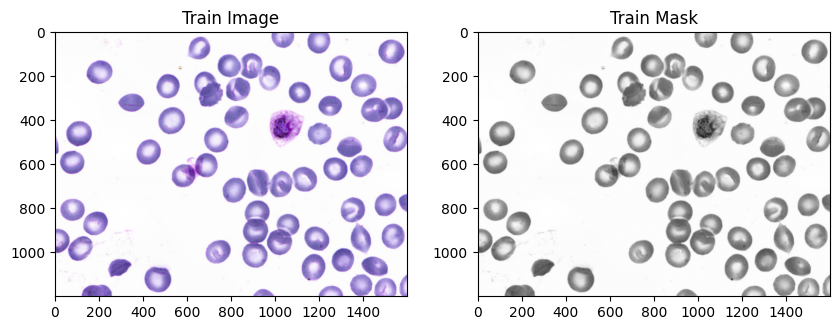

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_name = sorted(os.listdir(train_image_dir))[0]

image = cv2.imread(os.path.join(train_image_dir, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(os.path.join(train_image_dir, image_name), 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Train Image")

plt.subplot(1,2,2)
plt.imshow(mask,  cmap="gray")
plt.title("Train Mask")

plt.show()


In [ ]:
import numpy as np
import cv2
import os

sample_mask_name = sorted(os.listdir(train_mask_dir))[0]

sample_mask = cv2.imread(os.path.join(train_mask_dir, sample_mask_name), 0)

print("Unique mask values:", np.unique(sample_mask))


Unique mask values: [  0 255]


In [ ]:
!pip install -q scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.7 MB/s eta 0:00:00


In [ ]:
from sklearn.cluster import KMeans
import skfuzzy as fuzz

In [ ]:
def get_boundary(mask):
    mask_uint8 = (mask * 255).astype(np.uint8)
    edges = cv2.Canny(mask_uint8, 100, 200)
    edges_binary = np.where(edges > 0, 1, 0)
    return edges_binary


In [ ]:
def boundary_dice(true_mask, pred_mask):
    true_boundary = get_boundary(true_mask)
    pred_boundary = get_boundary(pred_mask)

    intersection = np.sum(true_boundary * pred_boundary)
    return (2. * intersection) / (
        np.sum(true_boundary) + np.sum(pred_boundary) + 1e-8
    )


In [ ]:
boundary_kmeans_list = []
boundary_fcm_list = []


In [ ]:
print(sorted(os.listdir(train_image_dir))[:5])
print(sorted(os.listdir(train_mask_dir))[:5])


['002f20ad-2ace-499c-9335-c9080bc3e6b5.png', '003a89b0-a095-417a-8dd6-f408339bbc68.png', '003d1cdc-0aec-430b-90e0-f4d82135b1ac.png', '005e60b6-77b8-458c-b57c-bfe0c7e7df78.png', '00a02700-2ea2-4590-9e15-ffc9160fd3de.png']
['002f20ad-2ace-499c-9335-c9080bc3e6b5.png', '003a89b0-a095-417a-8dd6-f408339bbc68.png', '003d1cdc-0aec-430b-90e0-f4d82135b1ac.png', '005e60b6-77b8-458c-b57c-bfe0c7e7df78.png', '00a02700-2ea2-4590-9e15-ffc9160fd3de.png']


In [ ]:
image_names = sorted(os.listdir(train_image_dir))

for image_name in image_names:

    image_path = os.path.join(train_image_dir, image_name)
    mask_path  = os.path.join(train_mask_dir, image_name)

    image = cv2.imread(image_path)
    mask  = cv2.imread(mask_path, 0)

    if image is None:
        print("Image failed:", image_name)
        continue

    if mask is None:
        print("Mask failed:", image_name)
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (128,128), interpolation=cv2.INTER_AREA)
    mask  = cv2.resize(mask, (128,128), interpolation=cv2.INTER_NEAREST)

    mask_binary = np.where(mask == 255, 1, 0)

    break


In [ ]:
    pixels = image.reshape((-1,3))
    pixels = np.float32(pixels)

    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixels)

    seg_kmeans = labels.reshape((128,128))

    cluster0_mean = np.mean(image[seg_kmeans == 0])
    cluster1_mean = np.mean(image[seg_kmeans == 1])

    if cluster0_mean > cluster1_mean:
        kmeans_binary = np.where(seg_kmeans == 0, 1, 0)
    else:
        kmeans_binary = np.where(seg_kmeans == 1, 1, 0)


In [ ]:
    pixels_fcm = image.reshape((-1,3)).T

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        pixels_fcm,
        c=2,
        m=2,
        error=0.005,
        maxiter=300
    )

    fcm_labels = np.argmax(u, axis=0)
    seg_fcm = fcm_labels.reshape((128,128))

    cluster0_mean = np.mean(image[seg_fcm == 0])
    cluster1_mean = np.mean(image[seg_fcm == 1])

    if cluster0_mean > cluster1_mean:
        fcm_binary = np.where(seg_fcm == 0, 1, 0)
    else:
        fcm_binary = np.where(seg_fcm == 1, 1, 0)


In [ ]:
    boundary_kmeans_list.append(
        boundary_dice(mask_binary, kmeans_binary)
    )

    boundary_fcm_list.append(
        boundary_dice(mask_binary, fcm_binary)
    )


In [ ]:
print("Average Boundary Dice - KMeans:",
      np.mean(boundary_kmeans_list))

print("Average Boundary Dice - FCM:",
      np.mean(boundary_fcm_list))


Average Boundary Dice - KMeans: 0.4623789421394031
Average Boundary Dice - FCM: 0.45966741126716393


In [ ]:
image_name = sorted(os.listdir(train_image_dir))[10]

image_path = os.path.join(train_image_dir, image_name)
mask_path  = os.path.join(train_mask_dir, image_name)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, 0)

image = cv2.resize(image, (128,128))
mask  = cv2.resize(mask, (128,128), interpolation=cv2.INTER_NEAREST)

mask_binary = np.where(mask == 255, 1, 0)


In [ ]:
from sklearn.cluster import KMeans

pixels = image.reshape((-1,3))

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pixels)

kmeans_labels = kmeans.labels_.reshape(128,128)

kmeans_binary = np.where(kmeans_labels == 1, 1, 0)


In [ ]:
import skfuzzy as fuzz

pixels_float = np.float64(pixels.T)

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    pixels_float, c=2, m=2, error=0.005, maxiter=1000
)

fcm_labels = np.argmax(u, axis=0)
fcm_labels = fcm_labels.reshape(128,128)

fcm_binary = np.where(fcm_labels == 1, 1, 0)


In [ ]:
true_boundary  = get_boundary(mask_binary)
kmeans_boundary = get_boundary(kmeans_binary)
fcm_boundary    = get_boundary(fcm_binary)


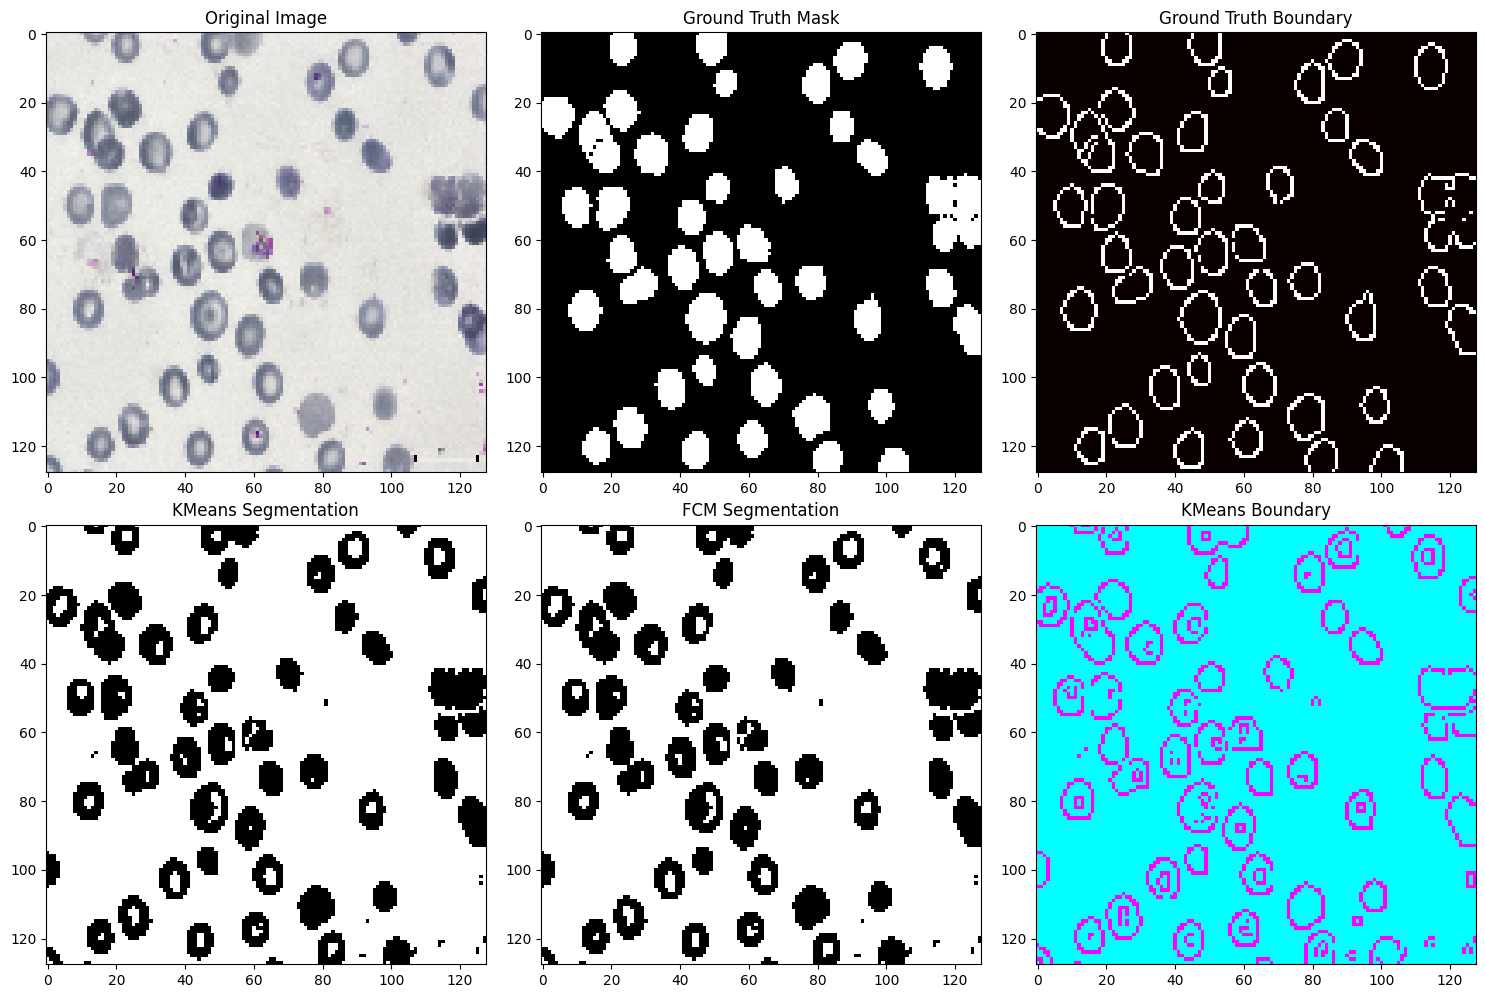

In [ ]:
-import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(2,3,2)
plt.imshow(mask_binary, cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(2,3,3)
plt.imshow(true_boundary, cmap="hot")
plt.title("Ground Truth Boundary")

plt.subplot(2,3,4)
plt.imshow(kmeans_binary, cmap="gray")
plt.title("KMeans Segmentation")

plt.subplot(2,3,5)
plt.imshow(fcm_binary, cmap="gray")
plt.title("FCM Segmentation")

plt.subplot(2,3,6)
plt.imshow(kmeans_boundary, cmap="cool")
plt.title("KMeans Boundary")

plt.tight_layout()
plt.show()
